In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import warnings
import numpy as np
from dateutil.relativedelta import relativedelta

In [2]:
import itertools

In [3]:
%matplotlib inline

## 1. Для начала преобразуем данные

In [4]:
data = pd.read_csv('forecast_task1.txt', sep=" ", header=None)

### Получим даты отдельно

In [5]:
dates = pd.concat([data[[0]], data[[2]], data[[4]], data[[6]]], axis=1)
dates_data = pd.DataFrame(data = dates.stack().reset_index()[0])
dates_data[[0]] = dates_data[[0]].apply(lambda x: pd.to_datetime(x, format='%d.%m.%Y'))

### Получим данные отдельно и сформируем из них DataFrame. Стоит понимать, что временные ряды - это ряды, где промежуток времени между последовательными показателями одинаковый, но в нашем случае есть пропуски. Мы заполним их с помощью интерполяции.

In [6]:
values = pd.concat([data[[1]], data[[3]], data[[5]], data[[7]]], axis=1, sort=False)
values_data = pd.DataFrame(data = values.stack().reset_index()[0])
values_data.columns = [1]

In [7]:
result = pd.concat([dates_data, values_data], axis=1, sort=False)
result.sort_values(by=0, inplace=True)
result = result.set_index(0)

In [8]:
result = result.reindex(pd.date_range('2019-01-01', '2019-06-03', freq='D'))
result.interpolate(inplace=True)
result = result.iloc[18:]

## 2. Построим график

### Мы убрали первые несколько наблюдений, которые мешают сезонности и оставили те, с которых начинается очередной сезон.

Text(0.5, 0, 'Dates')

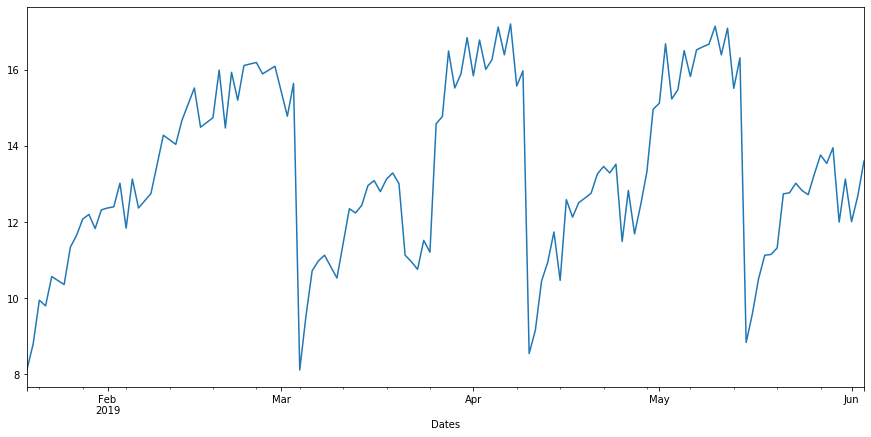

In [9]:
plt.figure(figsize=(15,7))
result[1].plot()
plt.xlabel('Dates')

#### По графику видно, что у временного ряда существует сезонность и цикличность. Это стоит учитывать в дальнейшем анализе. 

## 3. Проверка ряда на стационарность

### Будем проверять стационарность по критерию Дики-Фуллера. 

In [10]:
print("Критерий Дики-Фуллера:", sm.tsa.stattools.adfuller(result[1])[1])

Критерий Дики-Фуллера: 0.004180751505216363


### p-значение меньше 0.05, значит, с вероятностью 95% мы отклоняем нулевую гипотезу о наличии нестационарности и говорим о том, что наш ряд стационарен. Но мы же видим сезонность на графике, и также знаем, что не всегда критерию выше слепо стоит доверять. От сезонности стоит попытаться отойти, приведя ряд к более стационарному.

### Также сделаем сезонную декомпозицию, чтобы посмотреть, из чего "состоит" наш ряд.

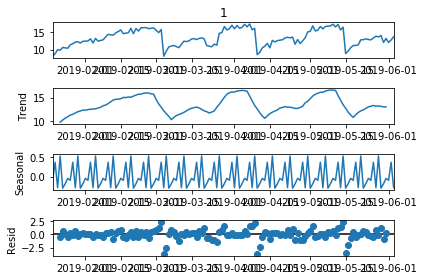

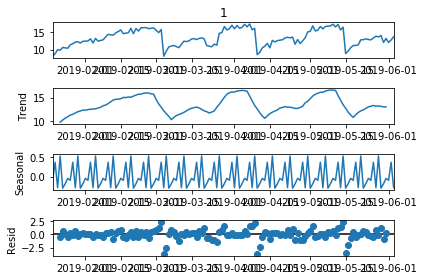

In [11]:
sm.tsa.seasonal_decompose(result[1]).plot()

### Сезонность достаточно хорошо выражена, это видно по Seasonal-графику, сначала показатель повышается, доходит до пика, а затем довольно резко снижается. Устойчивого тренда как такового нет. Сделаем преобразование Бокса-Кокса для стабилизации возможной дисперсии. 

In [12]:
def invboxcox(i, lmbda):
    if lmbda == 0:
        return (np.exp(i))
    else:
        return (np.exp(np.log(lmbda*i + 1)/lmbda))

In [13]:
result['param_diff'], lmbda = stats.boxcox(result[1])

### Применим дифференцирование к ряду. После его проведения по критерию Дики-Фуллера p-значение еще сильнее уменьшилось, ряд до сих пор стационарен.

In [14]:
result['new_param'] = result['param_diff'] - result['param_diff'].shift(1)

In [15]:
print("Критерий Дики-Фуллера:", sm.tsa.stattools.adfuller(result['new_param'][1:])[1])

Критерий Дики-Фуллера: 2.225959001512723e-27


### Также по графику первому видно, что сезонность получилась более сглаженная, что неплохо.

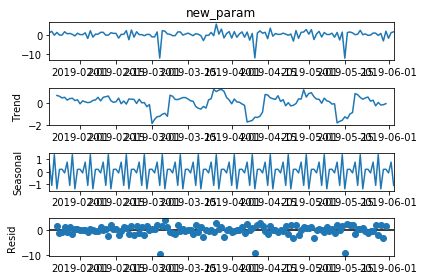

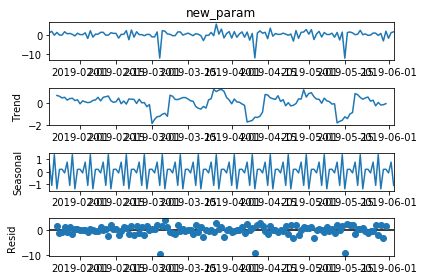

In [16]:
sm.tsa.seasonal_decompose(result['new_param'][1:]).plot()

## 3. Начнем моделирование, используем модель ARIMA

### Посмотрим на график автокорреляции, из него будем находить начальные приближения для параметров для модели ARIMA.

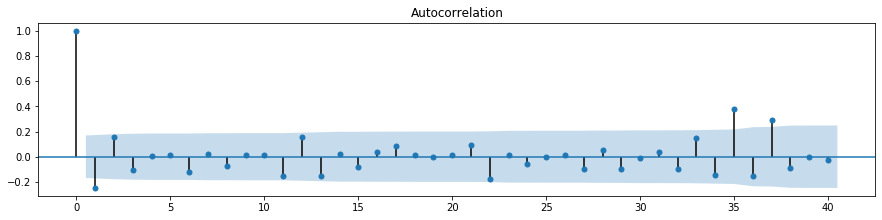

In [17]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(result['new_param'][1:].values.squeeze(), lags=40, ax=ax)
plt.show()

#### Начальное приближение для параметров в ARIMA: d (кол-во обычного диффер-ия), D (кол-во сезонного дифф-ия), p (кол-во предыдущих значений ряда), q (кол-во последних значений шумовой компоненты), P (авторегрессионные компоненты), Q (компоненты скользящего срднего).


### Построим график частичной авткорреляции

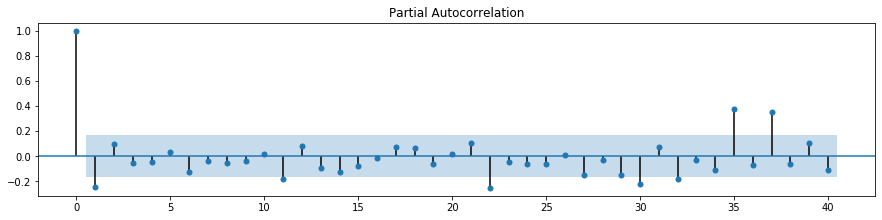

In [18]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_pacf(result['new_param'][1:].values.squeeze(), lags=40, ax=ax)
plt.show()

### Начнем перебор параметров и построение модели

In [19]:
d=1
D=1
p_s = range(0,3)
P_s = range(0,2)
q_s = range(0,3)
Q_s = range(0,2)

In [20]:
parameters_list = list(itertools.product(p_s,q_s,P_s,Q_s))
len(parameters_list)

36

### Будем смотреть на качество по критерию Акаике

In [23]:
warnings.filterwarnings('ignore')
aic_best = float('inf')
res_params = list()
best_aic = 0
best_param = tuple()
models = list()

for i in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(result['param_diff'], order=(i[0], d, i[1]), 
                                        seasonal_order=(i[2], D, i[3], 40)).fit()
    except:
        continue
    aic = model.aic
    
    #if aic < best_aic:
       # best_model=model
      #  best_aic=aic
      #  best_param=i
    res_params.append([i, aic])
    models.append(model)
    
warnings.filterwarnings('default')

In [24]:
result_table = pd.DataFrame(res_params, columns=['params', 'aic']).sort_values(by='aic', ascending=True).head(3)

### По критерию Акаике самая лучшая комбинация параметров - в первой строчке.

In [25]:
result_table

,params,aic
33,"(2, 2, 0, 1)",473.522378
35,"(2, 2, 1, 1)",474.659165
13,"(1, 0, 0, 1)",475.735619


In [26]:
top_model = models[33]

Text(0, 0.5, 'Residuals')

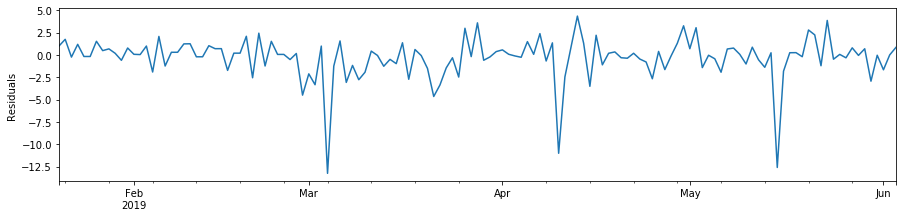

In [27]:
plt.figure(figsize=(15,7))
plt.subplot(211)
top_model.resid[1:].plot()
plt.ylabel('Residuals')

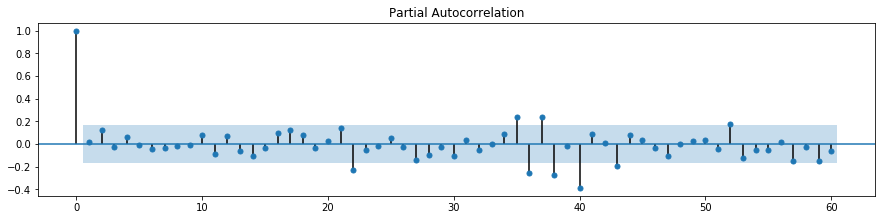

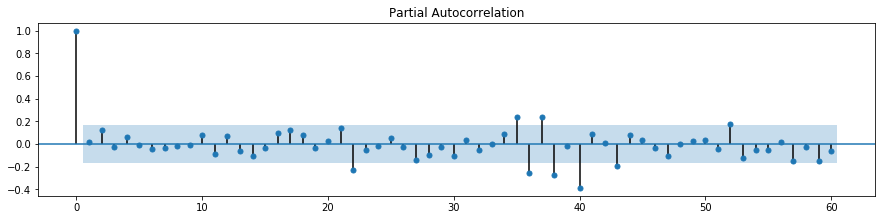

In [28]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,7))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(top_model.resid[1:].values.squeeze(), lags=60, ax=ax)

### На графике остатков не заметно никаких сильных зависимостей, так же и в автокорреляционной функции нет структуры.

### Проверим свойства остатков по критериям Стьюдента и Дики-Фуллера. 

In [29]:
print('Критерий Дики-Фуллера: ', sm.tsa.stattools.adfuller(top_model.resid[1:])[1])

Критерий Дики-Фуллера:  1.607370532901651e-20


In [30]:
print('Критерий Стьдента: ', stats.ttest_1samp(top_model.resid[1:], 0)[1])

Критерий Стьдента:  0.12368514043823108


### Критерий Стьюдента не отвергает гипотезу несмещенности. Критерий Дики-Фуллера отвергает гипотезу о нестационарности.

## 4. Построим модель, описывающую данные

In [33]:
warnings.filterwarnings('ignore')
result['sarima'] = invboxcox(top_model.fittedvalues, lmbda)

Text(0.5, 0, 'Dates')

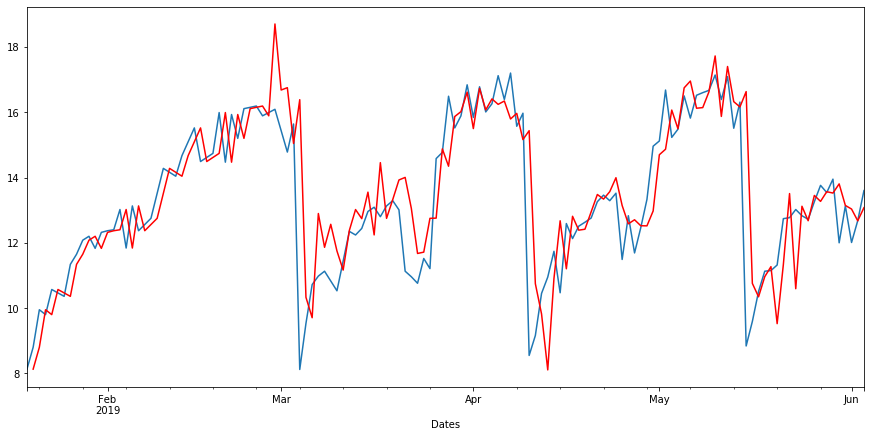

In [34]:
plt.figure(figsize=(15,7))
result[1].plot()
result.sarima[1:].plot(color='red')
plt.xlabel('Dates')

#### Модель улавливает тенденции в данных, для начала можно ее принять.

## 5. Строим прогноз

In [35]:
forecast = result[[1]]
dates = [datetime.strptime("2019-06-04", '%Y-%m-%d') + relativedelta(days=x) for x in range(0,60)]
forecast_data = pd.DataFrame(index=dates, columns=forecast.columns)
forecast = pd.concat([forecast, forecast_data])

In [36]:
forecast['predicted'] = invboxcox(top_model.predict(start=136, end=195), lmbda)

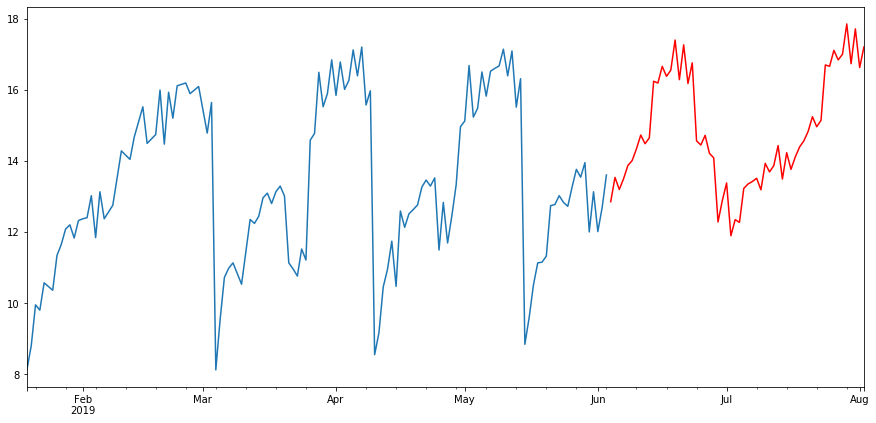

In [37]:
plt.figure(figsize=(15,7))
result[1].plot()
forecast['predicted'].plot(color='red')

### Предсказанные значения

In [38]:
forecast['predicted']

2019-01-19          NaN
2019-01-20          NaN
2019-01-21          NaN
2019-01-22          NaN
2019-01-23          NaN
                ...    
2019-07-29    17.848846
2019-07-30    16.731800
2019-07-31    17.710338
2019-08-01    16.623151
2019-08-02    17.204771
Freq: D, Name: predicted, Length: 196, dtype: float64

## Вывод

####  Как мы видим, модель, предсказывающая значения в будущем в принципе смогла "поймать" сезонность. Бесспорно, чтобы она работала лучше необходимо рассматривать больший диапазон ее парметров (p, q, P и т.д.). Однако, чтобы перебрать больше комбинаций параметров, нужны большие вычислительные мощности, которые не доступны обычному компьютеру. Но тем не менее, результат получился неплохой, чтобы в последствии все больше его улучшать.